In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
import random
import csv

In [2]:
def is_power_of_two(n):
  return (n & (n - 1) == 0) and n != 0


def generate_cache_accesses(
    num_operations=500,
    address_start=0,
    address_end=4096,
    repeat_percentage_range=(30, 70),
    alignment=4,  # Use 4 for aligned, 1 for unaligned
    density='dense'):  # 'sparse' or 'dense'
  
  if alignment == 4:
    # Aligned accesses
    addresses = list(range(address_start, address_end, alignment))
  else:
    # Unaligned accesses
    addresses = list(range(address_start, address_end))

  if density == 'dense':
    # Close together: reduce the range of addresses
    address_range = (address_end - address_start) // 4
    addresses = [address_start + (i * 4) for i in range(address_range)]
  elif density == 'sparse':
    # Spread out: use all addresses
    pass
  else:
    raise ValueError("Invalid density option. Use 'sparse' or 'dense'.")

  data_values = [
      "0x11111111",
      "0x22222222",
      "0x33333333",
      "0x44444444",
      "0x55555555",
      "0x66666666",
      "0x77777777",
      "0x88888888",
      "0x99999999",
      "0x12345678",
      "0x79824691",
      "0x16420982",
      "0x15946378",
      "0x687b890a",
      "0xf809b234",
  ]

  num_repeated_operations = int(num_operations *
                                random.uniform(*repeat_percentage_range) / 100)
  num_unique_operations = num_operations - num_repeated_operations

  unique_accesses = []
  for _ in range(num_unique_operations):
    address = random.choice(addresses)
    if random.choice([True, False]):
      unique_accesses.append(["R", f"0x{address:08X}", ""])
    else:
      data = random.choice(data_values)
      unique_accesses.append(["W", f"0x{address:08X}", data])

  repeated_accesses = random.choices(unique_accesses,
                                     k=num_repeated_operations)

  accesses = unique_accesses + repeated_accesses
  random.shuffle(accesses)

  return accesses


def save_accesses_to_csv(num_operations=500):
  accesses = generate_cache_accesses(num_operations=num_operations)

  file_path = f"cache_accesses_{num_operations}.csv"

  with open(file_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(accesses)

  print(f"Generated cache accesses and saved to {file_path}")

In [3]:



def run_c_program(cache_line_size, l1_cache_lines, l2_cache_lines):
  command = [
      "./project", "-c", "10000000", "--cacheline-size",
      str(cache_line_size), "--l1-lines",
      str(l1_cache_lines), "--l2-lines",
      str(l2_cache_lines), "--l1-latency", "4", "--l2-latency", "16",
      "--memory-latency", "400", "--tf=tracefile", f"cache_accesses_500.csv"
  ]

  result = subprocess.run(command, capture_output=True, text=True)
  if result.returncode != 0:
    print(f"Error running C program: {result.stderr}")

In [13]:
column_names = ['cycles', 'misses', 'hits', 'primitiveGateCount']

def read_results_from_csv(filename):
  if os.path.exists(filename):
    return pd.read_csv(filename, names=column_names, header=None)

In [19]:
save_accesses_to_csv(500)
run_c_program(64,32,128)

Generated cache accesses and saved to cache_accesses_500.csv


In [39]:
cache_line_sizes = [8, 16, 32, 64, 128, 256]
l1_cache_lines = [16, 32, 64, 128]
l2_cache_lines = [64, 128, 256]
column_names = ['cycles', 'misses', 'hits', 'primitiveGateCount']
result_list = [None] * 4
generate_cache_accesses(500)
for i,l1_lines in enumerate(l1_cache_lines):
  results_df = pd.DataFrame()
  for cache_line_size in cache_line_sizes:
      for l2_lines in [256]:
        run_c_program(cache_line_size, l1_lines, l2_lines)
        filename = 'results.csv'
        df = pd.DataFrame()
        df = read_results_from_csv(filename)
        df['cache_line_size'] = cache_line_size
        df['l1_cache_lines'] = l1_lines
        df['l2_cache_lines'] = l2_lines
        results_df = pd.concat([results_df,df], ignore_index=True)
  print(i)
  result_list[i] = results_df

print(result_list)

0
1
2
3
[   cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
0  279537     664   319               29887                8              16   
1  343313     585   391               51891               16              16   
2  450065     518   441               96167               32              16   
3  506961     430   507              184987               64              16   
4  517985     289   598              362895              128              16   
5  514129      32   734              718979              256              16   

   l2_cache_lines  
0             256  
1             256  
2             256  
3             256  
4             256  
5             256  ,    cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
0  278913     625   338               31293                8              32   
1  342449     531   420               54305               16              32   
2  448929     447   482              100613      

In [45]:
import numpy as np

colors = plt.cm.viridis(np.linspace(0, 1, len(result_list)))

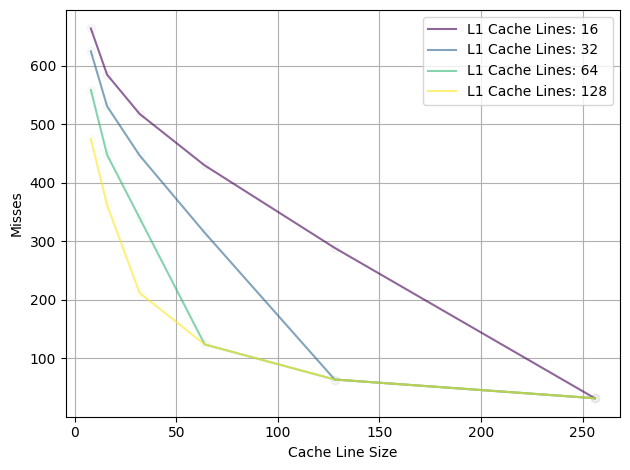

In [43]:
#plt.figure(figsize=(10, 6))
#for d in result_list:
#  for cls in cache_line_sizes:
#    subset = d[d['cache_line_size'] == cls]
#    print(subset)
#    plt.plot(subset['cache_line_size'],
#             subset['misses'],
#             label=f'Cache Line Size vs misses {cls}',
#             marker='o',
#             linestyle='-')
#  
#plt.xlabel("Cache Line Size")
#plt.ylabel("misses")
#plt.grid(True)
#plt.tight_layout()
#plt.show()

for i,d in enumerate(result_list):
  color = colors[i]
  x = d['cache_line_size']
  y = d['misses']

  plt.plot(x,y, label = f"L1 Cache Lines: {l1_cache_lines[i]}",color = color,alpha=0.6)
  plt.scatter(x, y, color=color, marker='o',alpha=0.03)

plt.xlabel("Cache Line Size")
plt.ylabel("Misses")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

   cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
0  276513     475   418               39577                8             128   

   l2_cache_lines  
0             256  
   cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
1  339745     362   512               68637               16             128   

   l2_cache_lines  
1             256  
   cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
2  445169     212   602              127137               32             128   

   l2_cache_lines  
2             256  
   cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
3  502065     124   666              244517               64             128   

   l2_cache_lines  
3             256  
   cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
4  514385      64   712              479657              128             128   

   l2_cache_lines  
4             2

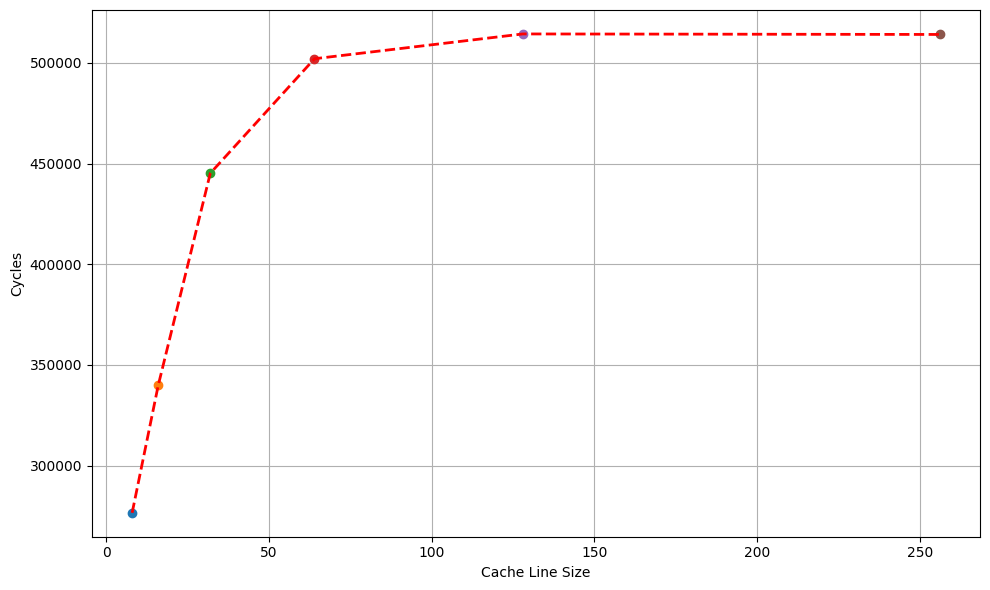

In [29]:


plt.figure(figsize=(10, 6))

for cls in cache_line_sizes:
  subset = results_df[results_df['cache_line_size'] == cls]
  print(subset)
  plt.plot(subset['cache_line_size'],
           subset['cycles'],
           label=f'Cache Line Size {cls}',
           marker='o',
           linestyle='-')

median_values = results_df.groupby(
    'cache_line_size')['cycles'].median().reset_index()

plt.plot(median_values['cache_line_size'],
         median_values['cycles'],
         color='red',
         linestyle='--',
         linewidth=2,
         label='Median of Cycles')

plt.xlabel("Cache Line Size")
plt.ylabel("Cycles")
plt.grid(True)
plt.tight_layout()
plt.show()

Empty DataFrame
Columns: [cycles, misses, hits, primitiveGateCount, cache_line_size, l1_cache_lines, l2_cache_lines]
Index: []
    cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
0     3639       4     0               35361                8              32   
1     3639       4     0               35361               16              32   
2     3639       4     0               35361               32              32   
3     3639       4     0               35361               64              32   
4     3639       4     0               35361              128              32   
5     3639       4     0               35361                8              32   
6     3639       4     0               35361               16              32   
7     3639       4     0               35361               32              32   
8     3639       4     0               35361               64              32   
9     3639       4     0               35361              128  

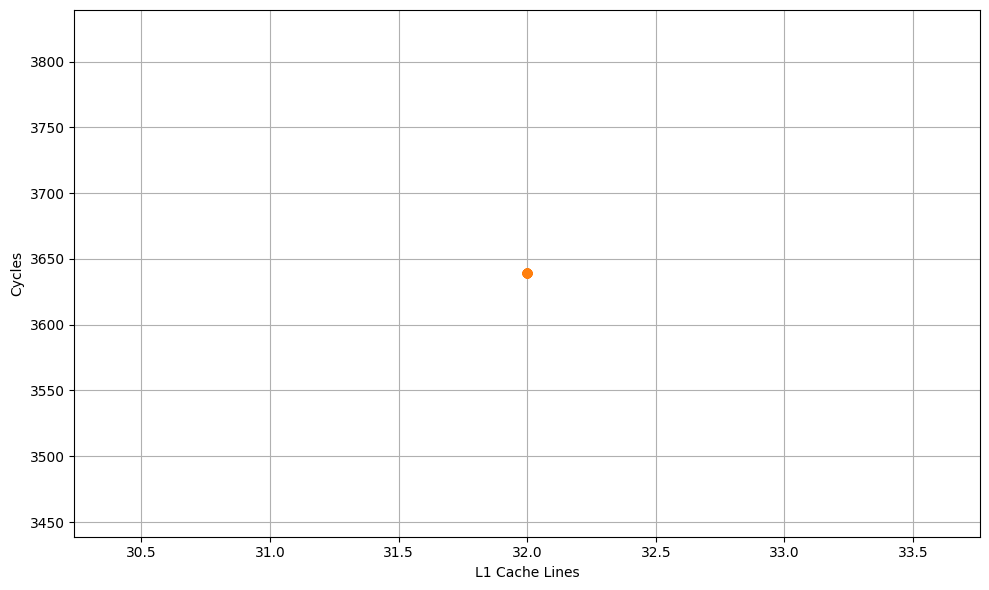

In [9]:
plt.figure(figsize=(10, 6))


for l1s in l1_cache_lines:
  subset = results_df[results_df['l1_cache_lines'] == l1s]
  print(subset)
  plt.plot(subset['l1_cache_lines'],
           subset['cycles'],
           label=f'l1_cache_lines {l1s}',
           marker='o',
           linestyle='-')
  
plt.xlabel("L1 Cache Lines")
plt.ylabel("Cycles")
plt.grid(True)
plt.tight_layout()
plt.show()

Empty DataFrame
Columns: [cycles, misses, hits, primitiveGateCount, cache_line_size, l1_cache_lines, l2_cache_lines]
Index: []
    cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
0     3639       4     0               35361                8              32   
1     3639       4     0               35361               16              32   
2     3639       4     0               35361               32              32   
3     3639       4     0               35361               64              32   
4     3639       4     0               35361              128              32   
5     3639       4     0               35361                8              32   
6     3639       4     0               35361               16              32   
7     3639       4     0               35361               32              32   
8     3639       4     0               35361               64              32   
9     3639       4     0               35361              128  

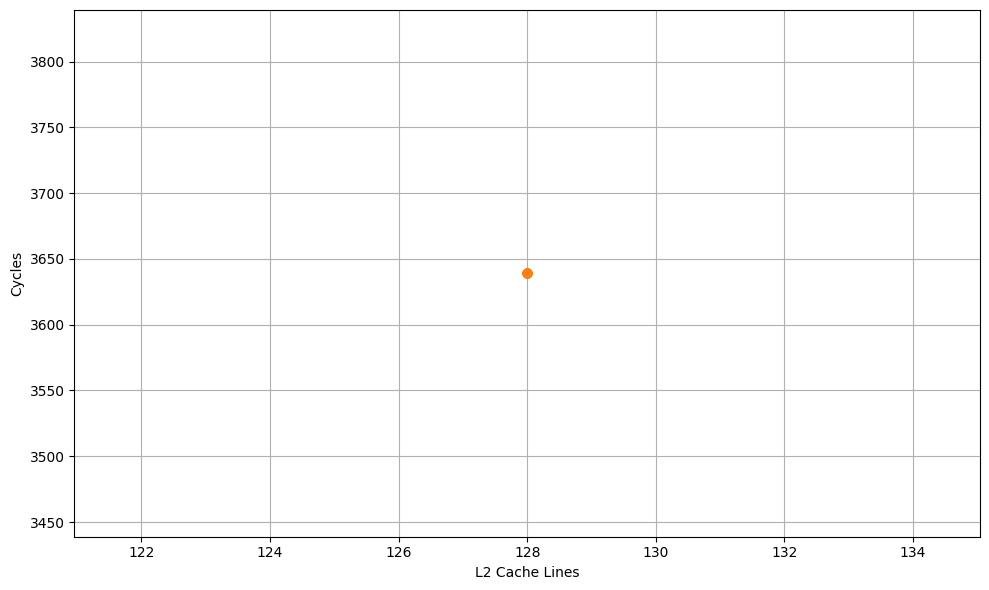

In [10]:
plt.figure(figsize=(10, 6))


for l2s in l2_cache_lines:
  subset = results_df[results_df['l2_cache_lines'] == l2s]
  print(subset)
  plt.plot(subset['l2_cache_lines'],
           subset['cycles'],
           label=f'l1_cache_lines {l2s}',
           marker='o',
           linestyle='-')
  
plt.xlabel("L2 Cache Lines")
plt.ylabel("Cycles")
plt.grid(True)
plt.tight_layout()
plt.show()